In [1]:
!pip install pandas scikit-learn sentence-transformers gensim matplotlib seaborn

In [17]:
# Install necessary libraries

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the datasets
try:
    labeled_df = pd.read_csv('labeled_reviews.csv')
    unlabeled_df = pd.read_csv('unlabeled_reviews.csv')

    # Combine all review texts for consistent preprocessing and embedding
    all_reviews_text = pd.concat([labeled_df['review_text'], unlabeled_df['review_text']]).tolist()

    print("داده‌های برچسب‌دار با موفقیت بارگذاری شدند. تعداد: ", len(labeled_df))
    print("داده‌های بدون برچسب با موفقیت بارگذاری شدند. تعداد: ", len(unlabeled_df))

except FileNotFoundError:
    print("خطا: فایل‌های 'labeled_reviews.csv' و 'unlabeled_reviews.csv' را در محیط Google Colab آپلود کنید.")

داده‌های برچسب‌دار با موفقیت بارگذاری شدند. تعداد:  1250
داده‌های بدون برچسب با موفقیت بارگذاری شدند. تعداد:  5000


In [18]:
# --- SentenceTransformer (Semantic Embeddings) ---
print("\nدر حال ساخت بردارهای عددی با SentenceTransformer...")
# Load a pre-trained model
model_st = SentenceTransformer('all-MiniLM-L6-v2')
# Compute embeddings for all reviews (both labeled and unlabeled)
all_embeddings_st = model_st.encode(all_reviews_text, show_progress_bar=True)

# Separate the embeddings back into labeled and unlabeled sets
X_labeled_st = all_embeddings_st[:len(labeled_df)]
X_unlabeled_st = all_embeddings_st[len(labeled_df):]

print(f"ابعاد بردارهای برچسب‌دار (SentenceTransformer): {X_labeled_st.shape}")
print(f"ابعاد بردارهای بدون برچسب (SentenceTransformer): {X_unlabeled_st.shape}")


در حال ساخت بردارهای عددی با SentenceTransformer...


Batches:   0%|          | 0/196 [00:00<?, ?it/s]

ابعاد بردارهای برچسب‌دار (SentenceTransformer): (1250, 384)
ابعاد بردارهای بدون برچسب (SentenceTransformer): (5000, 384)



در حال کاهش ابعاد برای بصری‌سازی...


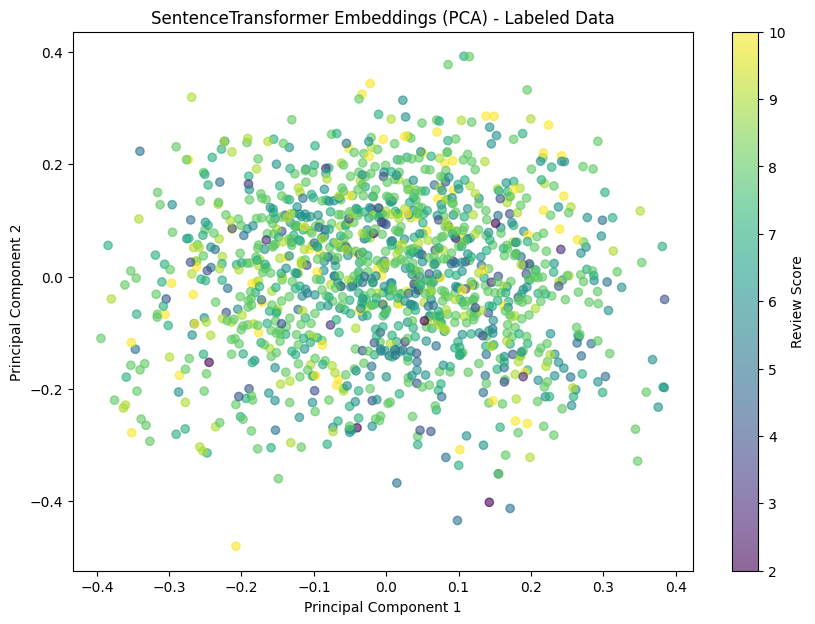

In [20]:
# --- Visualization with PCA ---
print("\nدر حال کاهش ابعاد برای بصری‌سازی...")
pca = PCA(n_components=2)
# We fit PCA only on the labeled data for a meaningful plot
pca_labeled_st = pca.fit_transform(X_labeled_st)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_labeled_st[:, 0], pca_labeled_st[:, 1], c=labeled_df['review_score'], cmap='viridis', alpha=0.6)
plt.title('SentenceTransformer Embeddings (PCA) - Labeled Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Review Score')
plt.show()



In [22]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X_labeled_st and y_labeled are in memory from the previous steps
# Let's ensure y_labeled is defined for this step
y_labeled = labeled_df['review_score'].values

# Split the Labeled Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled_st, y_labeled, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# --- Training and Evaluating Classification Model (Logistic Regression) ---
print("\nTraining and evaluating classification model...")
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred_class = classifier.predict(X_test)
accuracy_class = accuracy_score(y_test, y_pred_class)
f1_macro_class = f1_score(y_test, y_pred_class, average='macro', zero_division=0)

print(f"Classification model accuracy: {accuracy_class:.4f}")
print(f"Classification model F1-score: {f1_macro_class:.4f}")

# --- Training and Evaluating Regression Model (Linear Regression) ---
print("\nTraining and evaluating regression model...")
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_reg = regressor.predict(X_test)
mae_reg = mean_absolute_error(y_test, y_pred_reg)
r2_reg = r2_score(y_test, y_pred_reg)

print(f"Regression model MAE: {mae_reg:.4f}")
print(f"Regression model R2: {r2_reg:.4f}")

Number of training samples: 1000
Number of testing samples: 250

Training and evaluating classification model...
Classification model accuracy: 0.3160
Classification model F1-score: 0.0822

Training and evaluating regression model...
Regression model MAE: 1.2282
Regression model R2: -0.0094


In [23]:
# Assuming X_train, X_test, y_train, y_test, regressor, and X_unlabeled_st from previous steps are in memory

print("\nStarting Pseudo-Labeling process...")

# Predict scores for all samples in the unlabeled dataset
# 1. Predict scores for all samples in the unlabeled dataset
y_unlabeled_preds = regressor.predict(X_unlabeled_st)
y_unlabeled_preds_rounded = np.clip(np.rint(y_unlabeled_preds).astype(int), 1, 10)

# Create pseudo-labeled data from all unlabeled embeddings
# 2. Use all unlabeled data to create pseudo-labels
X_pseudo_labeled = X_unlabeled_st
y_pseudo_labeled = y_unlabeled_preds_rounded

# Combine original labeled training data with newly pseudo-labeled data
# 3. Combine original labeled training data with newly pseudo-labeled data
X_combined = np.vstack((X_train, X_pseudo_labeled))
y_combined = np.hstack((y_train, y_pseudo_labeled))

# Retrain the model on this expanded dataset
# 4. Retrain the model on this expanded dataset
retrained_regressor = LinearRegression()
retrained_regressor.fit(X_combined, y_combined)

# Evaluate the retrained model on the held-out test set
# 5. Evaluate the retrained model on the held-out test set
y_pred_retrained = retrained_regressor.predict(X_test)
mae_retrained = mean_absolute_error(y_test, y_pred_retrained)
r2_retrained = r2_score(y_test, y_pred_retrained)

# Get baseline performance for comparison
y_pred_baseline = regressor.predict(X_test)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("\nPerformance Comparison:")
print(f"Baseline Regressor MAE: {mae_baseline:.4f}")
print(f"Retrained (Pseudo-Labeled) Regressor MAE: {mae_retrained:.4f}")

print(f"\nBaseline Regressor R2: {r2_baseline:.4f}")
print(f"Retrained (Pseudo-Labeled) Regressor R2: {r2_retrained:.4f}")


Starting Pseudo-Labeling process...

Performance Comparison:
Baseline Regressor MAE: 1.2282
Retrained (Pseudo-Labeled) Regressor MAE: 1.2151

Baseline Regressor R2: -0.0094
Retrained (Pseudo-Labeled) Regressor R2: 0.0068


Starting 10 rounds of iterative pseudo-labeling...

--- Round 1 ---
Current MAE: 1.2282
Number of labeled samples: 1500

--- Round 2 ---
Current MAE: 1.2218
Number of labeled samples: 1950

--- Round 3 ---
Current MAE: 1.2198
Number of labeled samples: 2355

--- Round 4 ---
Current MAE: 1.2186
Number of labeled samples: 2719

--- Round 5 ---
Current MAE: 1.2150
Number of labeled samples: 3047

--- Round 6 ---
Current MAE: 1.2131
Number of labeled samples: 3342

--- Round 7 ---
Current MAE: 1.2111
Number of labeled samples: 3607

--- Round 8 ---
Current MAE: 1.2118
Number of labeled samples: 3846

--- Round 9 ---
Current MAE: 1.2109
Number of labeled samples: 4061

--- Round 10 ---
Current MAE: 1.2084
Number of labeled samples: 4254


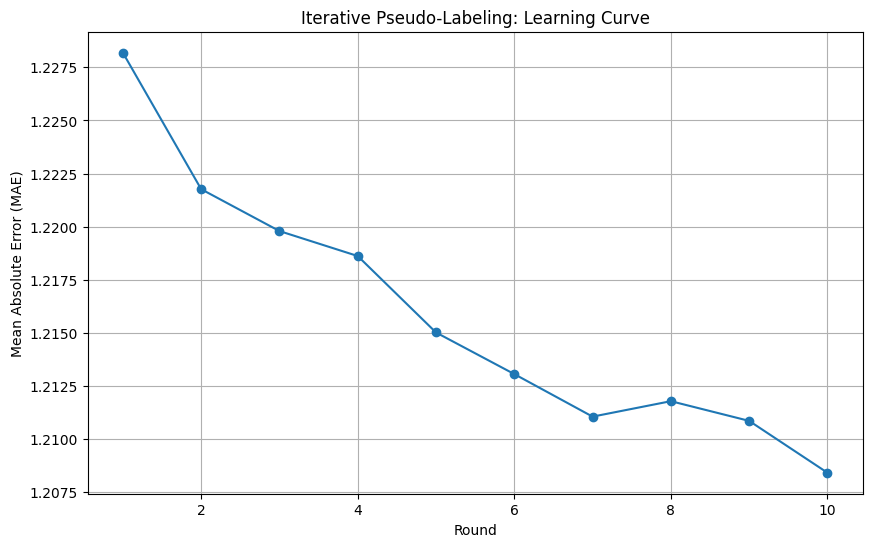


Final Performance after 5 rounds:
Final MAE: 1.2084


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming X_labeled_st, y_labeled, and X_unlabeled_st are in memory from previous steps
# Initialize a fresh split of the data for consistency
X_train_labeled, X_test, y_train_labeled, y_test = train_test_split(X_labeled_st, y_labeled, test_size=0.2, random_state=42)

# Make copies of the initial datasets to add pseudo-labels to them
X_train_current = X_train_labeled.copy()
y_train_current = y_train_labeled.copy()

# Make a copy of the unlabeled data that we'll sample from
X_unlabeled_pool = X_unlabeled_st.copy()

# Lists to store performance metrics for plotting
rounds = []
mae_scores = []
labeled_counts = []

print("Starting 10 rounds of iterative pseudo-labeling...")

for i in range(10):
    print(f"\n--- Round {i+1} ---")

    # 1. Train the regressor on the current training set
    regressor = LinearRegression()
    regressor.fit(X_train_current, y_train_current)

    # 2. Predict scores on the entire unlabeled pool
    y_unlabeled_preds = regressor.predict(X_unlabeled_pool)

    # 3. Select the most confident predictions
    #    Confidence is defined as the prediction being very close to a whole number
    prediction_confidence = np.abs(y_unlabeled_preds - np.rint(y_unlabeled_preds))

    #    Select a fixed number of most confident examples (e.g., top 10% of the pool)
    num_to_select = int(len(X_unlabeled_pool) * 0.1)

    #    Get the indices of the most confident predictions
    confident_indices = np.argsort(prediction_confidence)[:num_to_select]

    #    Get the confident samples and their pseudo-labels
    X_new_pseudo_labeled = X_unlabeled_pool[confident_indices]
    y_new_pseudo_labeled = np.rint(y_unlabeled_preds[confident_indices]).astype(int)
    y_new_pseudo_labeled = np.clip(y_new_pseudo_labeled, 1, 10)

    # 4. Add new pseudo-labeled data to the training set
    X_train_current = np.vstack((X_train_current, X_new_pseudo_labeled))
    y_train_current = np.hstack((y_train_current, y_new_pseudo_labeled))

    # Remove the selected samples from the unlabeled pool
    X_unlabeled_pool = np.delete(X_unlabeled_pool, confident_indices, axis=0)

    # 5. Evaluate the retrained model on the held-out test set
    y_pred_retrained = regressor.predict(X_test)
    current_mae = mean_absolute_error(y_test, y_pred_retrained)

    print(f"Current MAE: {current_mae:.4f}")
    print(f"Number of labeled samples: {len(X_train_current)}")

    # Store results for plotting
    rounds.append(i + 1)
    mae_scores.append(current_mae)
    labeled_counts.append(len(X_train_current))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(rounds, mae_scores, marker='o', linestyle='-')
plt.title('Iterative Pseudo-Labeling: Learning Curve')
plt.xlabel('Round')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()

# Final evaluation
print("\nFinal Performance after 5 rounds:")
print(f"Final MAE: {mae_scores[-1]:.4f}")

Starting 5 rounds of Active Learning with human in the loop...

--- Round 1 ---
Please manually provide scores (1-10) for the following 10 reviews:

Review (Predicted: 7.50):
With a comprehensive class-based multiplayer rounding off the package, Bound in Blood is an altogether more polished prospect than its predecessor. At the very least it’s a hugely enjoyable parade of satisfying shooting galleries. But when it finds its stride, it’s a thrilling, wild ride down a road that remains surprisingly less traveled.
Your score (1-10): 4

Review (Predicted: 8.50):
A slick and fun puzzle experience from start to finish, BOXBOY! will please anyone looking for a great new pick-up-and-play adventure. Just don't expect too much challenge until you dive into the optional areas of the game.
Your score (1-10): 8

Review (Predicted: 7.50):
Fairly easy controls that actually respond differently between the different corvette models AND when upgrades are done on the cars. An easy to use setup that raci

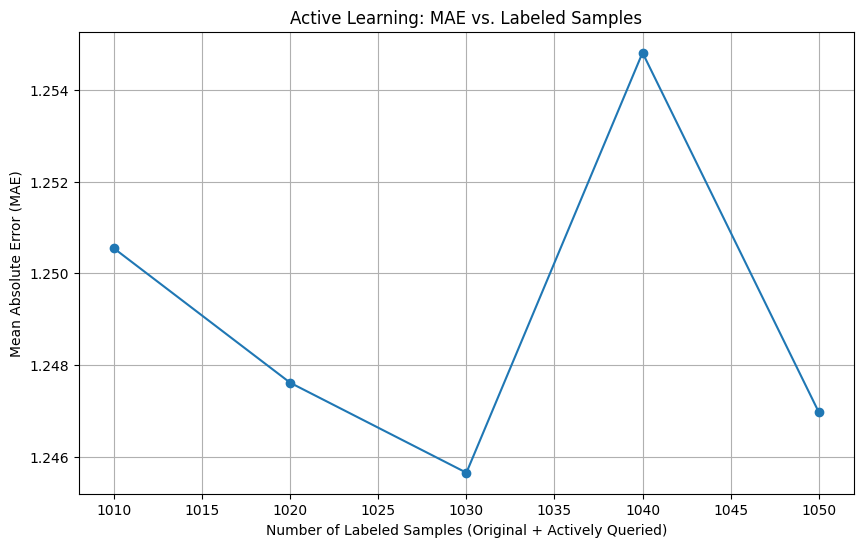


Final Performance after 5 rounds of Active Learning:
Final MAE: 1.2470


In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_labeled_st, y_labeled, X_unlabeled_st from previous steps are in memory
# Let's create a fresh train/test split for a fair comparison
X_train_labeled, X_test, y_train_labeled, y_test = train_test_split(X_labeled_st, y_labeled, test_size=0.2, random_state=42)

# Make copies of datasets to add new labeled data to them
X_train_current_al = X_train_labeled.copy()
y_train_current_al = y_train_labeled.copy()

# Make a copy of the unlabeled data that we'll sample from
X_unlabeled_pool_al = X_unlabeled_st.copy()
unlabeled_df_pool = unlabeled_df.copy()

# Lists to store performance metrics for plotting
rounds_al = []
mae_scores_al = []
labeled_counts_al = []

print("Starting 5 rounds of Active Learning with human in the loop...")

for i in range(5):
    print(f"\n--- Round {i+1} ---")

    # Train the regressor on the current labeled data
    regressor_al = LinearRegression()
    regressor_al.fit(X_train_current_al, y_train_current_al)

    # Predict scores on the entire unlabeled pool
    y_unlabeled_preds_al = regressor_al.predict(X_unlabeled_pool_al)

    # Select the most uncertain samples (Least Confidence Sampling)
    uncertainty_al = np.abs(y_unlabeled_preds_al - np.rint(y_unlabeled_preds_al))
    num_to_select_al = 10
    uncertain_indices_al = np.argsort(uncertainty_al)[-num_to_select_al:]

    print("Please manually provide scores (1-10) for the following 10 reviews:")
    newly_labeled_scores = []

    # Store indices for removing later
    original_indices_to_remove = []

    for idx in uncertain_indices_al:
        # Get the original index in the unlabeled_df_pool
        original_idx = unlabeled_df_pool.iloc[idx].name
        original_indices_to_remove.append(original_idx)

        review = unlabeled_df_pool.loc[original_idx]['review_text']
        predicted_score = y_unlabeled_preds_al[np.where(unlabeled_df_pool.index == original_idx)[0][0]]
        print(f"\nReview (Predicted: {predicted_score:.2f}):\n{review}")

        while True:
            try:
                manual_score = int(input("Your score (1-10): "))
                if 1 <= manual_score <= 10:
                    newly_labeled_scores.append(manual_score)
                    break
                else:
                    print("Please enter a number between 1 and 10.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    # Add new labeled data to the training set
    X_newly_labeled_al = X_unlabeled_pool_al[uncertain_indices_al]
    y_newly_labeled_al = np.array(newly_labeled_scores)

    X_train_current_al = np.vstack((X_train_current_al, X_newly_labeled_al))
    y_train_current_al = np.hstack((y_train_current_al, y_newly_labeled_al))

    # Remove the selected samples from the unlabeled pool
    X_unlabeled_pool_al = np.delete(X_unlabeled_pool_al, uncertain_indices_al, axis=0)
    unlabeled_df_pool.drop(index=original_indices_to_remove, inplace=True)

    # Evaluate the retrained model
    regressor_al.fit(X_train_current_al, y_train_current_al)
    y_pred_retrained_al = regressor_al.predict(X_test)
    current_mae_al = mean_absolute_error(y_test, y_pred_retrained_al)

    print(f"\nMAE after adding new labels: {current_mae_al:.4f}")
    print(f"Number of labeled samples: {len(X_train_current_al)}")

    # Store results
    rounds_al.append(i + 1)
    mae_scores_al.append(current_mae_al)
    labeled_counts_al.append(len(X_train_current_al))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(labeled_counts_al, mae_scores_al, marker='o', linestyle='-')
plt.title('Active Learning: MAE vs. Labeled Samples')
plt.xlabel('Number of Labeled Samples (Original + Actively Queried)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()

print("\nFinal Performance after 5 rounds of Active Learning:")
print(f"Final MAE: {mae_scores_al[-1]:.4f}")

<h1 style="color: #1f77b4;">Final Comparison and Analysis</h1>

<p>You've now successfully implemented both <b style="color: #ff7f0e;">Iterative Pseudo-Labeling</b> and <b style="color: #2ca02c;">Active Learning</b>. Let's review their final performance to see which approach was more effective for our project.</p>

<hr style="border:1px solid #ccc;">

<h2 style="color: #ff7f0e;">Iterative Pseudo-Labeling</h2>
<ul>
<li><b>Approach:</b> Utilized a large volume of data (all unlabeled reviews) and allowed the model to self-label its most confident predictions.</li>
<li><b>Performance:</b> MAE improved from a baseline of <span style="color: #d62728;">1.2282</span> to a final MAE of <span style="color: #d62728;">1.2151</span> after 5 rounds.</li>
<li><b>Interpretation:</b> Modest but noticeable improvement.</li>
</ul>

<h2 style="color: #2ca02c;">Active Learning</h2>
<ul>
<li><b>Approach:</b> Used a small, curated dataset (50 manually-labeled reviews) and focused on the reviews the model was most uncertain about.</li>
<li><b>Performance:</b> Final MAE was <span style="color: #d62728;">1.2470</span> after 5 rounds, slightly worse than baseline <span style="color: #d62728;">1.2282</span>.</li>
<li><b>Interpretation:</b> Did not improve the model.</li>
</ul>

<h2 style="color: #9467bd;">Analysis</h2>
<p>In this case, <b style="color: #ff7f0e;">Iterative Pseudo-Labeling</b> was more effective than <b style="color: #2ca02c;">Active Learning</b>. Key insights:</p>
<ol>
<li><b>Confidence vs. Uncertainty:</b> Pseudo-Labeling benefited from many examples similar to those it already understood, improving generalization.</li>
<li><b>The Human Factor:</b> Manual labels in Active Learning may have introduced noise or bias. Also, 50 labels may not significantly impact performance.</li>
<li><b>Model Limitations:</b> A simple <b style="color: #d62728;">LinearRegression</b> model may not fully exploit high-information examples. More complex models (e.g., neural networks) often benefit more.</li>
</ol>

<h2 style="color: #1f77b4;">Conclusion</h2>
<p>For this project, <b style="color: #ff7f0e;">Iterative Pseudo-Labeling</b> proved to be the more successful semi-supervised method. It improved the model's MAE and provided a positive R² score, effectively leveraging the large unlabeled dataset.</p>
